## Transfer learning tuning and saving best models:

### VGG16:
 * model parameter and other information can be found below:
     * [source](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)
     
  * base_model: use vgg16 as base model and freeze at bottleneck layer (stop right before flatten layer). 
  * top_model: tune dense layers (parameters are inspired by the blog source):
     * batch_size 16 seems to work best for small data set 
  * freezed the first 15 layers and fined tuned the last 5 layers (block5 and fully connected layer).
  * extra blog source for callbacks and saving models:
    * [call_backs for best weights](https://machinelearningmastery.com/check-point-deep-learning-models-keras/)
    * [saving models](https://machinelearningmastery.com/save-load-keras-deep-learning-models/)

### ResNet50:
  * Use Resnet50 to help further improve accuracy:
      * see [base model info comparison](https://medium.com/@sidereal/cnns-architectures-lenet-alexnet-vgg-googlenet-resnet-and-more-666091488df5)
      * [resnet50 blog](https://towardsdatascience.com/understanding-and-coding-a-resnet-in-keras-446d7ff84d33)
     
  * base_model: use RESNET50 and freeze at bottleneck layer (stop right before 2D AVERAGE POOL). 
  * top_model: tune dense layers (parameters are inspired by a few sources):
     * [source1](https://www.kaggle.com/suniliitb96/tutorial-keras-transfer-learning-with-resnet50)
     * [source2](https://www.kaggle.com/pmigdal/transfer-learning-with-resnet-50-in-keras)
     * [source3](https://towardsdatascience.com/transfer-learning-for-image-classification-using-keras-c47ccf09c8c8)
  * unfreezed the last 5 layers (after activation48 and fully connected layer).
  
---
#### This cell is required in order to use GPU for running the model 

In [1]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import keras
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
# dynamically grow the memory used on the GPU
config.gpu_options.allow_growth = True 
# to log device placement (on which device the operation ran)
# (nothing gets printed in Jupyter, only if you run it standalone)
config.log_device_placement = True  
# set this TensorFlow session as the default session for Keras                                    
sess = tf.Session(config=config)
set_session(sess) 
keras.backend.get_session().run(tf.global_variables_initializer())  

Using TensorFlow backend.
W0908 00:03:51.078120 140224516454208 deprecation_wrapper.py:119] From /home/mindy/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0908 00:03:51.078919 140224516454208 deprecation_wrapper.py:119] From /home/mindy/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:207: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



---
### Import necessary libraries:

In [32]:
# from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score

# from sklearn.utils import class_weight
# from keras.callbacks import ModelCheckpoint
# from keras import optimizers

from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.applications.vgg16 import VGG16

# from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
# from keras.models import Sequential, Model, model_from_json

import sys
import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# %matplotlib inline

In [5]:
df = pd.read_pickle('../pickle_files/pic_df.pkl')

## load in custom preprocess function

In [33]:
%load_ext autoreload
%autoreload 1

sys.path.append("../python_files/")

import vgg16_preprocess
import model_tuning


%aimport vgg16_preprocess
%aimport model_tuning


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Get bottleneck features to tune top models

#### Save bottleneck_features

In [34]:
train_df, test_df = model_tuning.save_bottleneck_features('hat',ResNet50,preprocess_input,None,(224,224),
                                                         '../tuning_data/resnet_data/bottleneck_resnet_train.npy',
                                                         '../tuning_data/resnet_data/bottleneck_resnet_test.npy')

Found 522 validated image filenames.
Found 131 validated image filenames.


### Quick tuning of top models 

#### run train_top_model and save results in tuning_data

In [35]:
model_tuning.train_top_model(train_df, test_df, 20, 'hat', 'resnet50',
                             None, preprocess_input, (224,224),
                             '../tuning_data/resnet_data/bottleneck_resnet_train.npy',
                            '../tuning_data/resnet_data/bottleneck_resnet_test.npy',
                            '../tuning_data/resnet_data/bottneck_best_weights.h5')

Found 522 validated image filenames belonging to 2 classes.
Found 131 validated image filenames belonging to 2 classes.
Train on 512 samples, validate on 128 samples
Epoch 1/20
512/512 [==============================] - 1s 1ms/step - loss: 0.5827 - acc: 0.7930 - val_loss: 0.1502 - val_acc: 0.9453

Epoch 00001: val_acc improved from -inf to 0.94531, saving model to ../tuning_data/resnet_data/bottneck_best_weights.h5
Epoch 2/20
512/512 [==============================] - 0s 301us/step - loss: 0.1773 - acc: 0.9336 - val_loss: 0.2131 - val_acc: 0.9219

Epoch 00002: val_acc did not improve from 0.94531
Epoch 3/20
512/512 [==============================] - 0s 302us/step - loss: 0.1086 - acc: 0.9609 - val_loss: 0.1745 - val_acc: 0.9375

Epoch 00003: val_acc did not improve from 0.94531
Epoch 4/20
512/512 [==============================] - 0s 302us/step - loss: 0.0671 - acc: 0.9766 - val_loss: 0.2209 - val_acc: 0.9375

Epoch 00004: val_acc did not improve from 0.94531
Epoch 5/20
512/512 [======

### Fine Tune Top Model to improve accuracy

In [17]:
def fine_tune_model(train_df, test_df,epoch, batch_size,label, 
                    model_type,dim, rescale, preprocess_func,print_model = False):
    '''
    inputs:
    train_df, test_df: dataframes returned from save_bottleneck_features functions 
    epoch: num of epochs in fit 
    batch_size: same as image generator batch size 
    label: a string, eyewear, hat, or beard
    model_type: resnet50 or vgg16
    dim: 224 or 150 
    rescale: None resnet50, 1./255 for vgg16
    preprocess_func: depends on resnet or vgg16
    return model 
    '''
    # build model and freeze top layers
    # input_shape: width, height, RGB (from image generator)
    if model_type == 'resnet50':
        base_model = ResNet50(weights='imagenet',include_top=False, input_shape=(dim,dim,3))
        # build top model
        top_model = resnet50_model(base_model.output_shape[1:],0.25)
    if model_type == 'vgg16':
        base_model = VGG16(weights='imagenet',include_top=False, input_shape=(dim,dim,3))
        top_model = vgg16_model(base_model.output_shape[1:],0.5)
    # load saved weights to fine tune parameters 
    top_model.load_weights(f'../tuning_data/VGG_16_tuning/top_model_weights_{label}.h5')
    # add top model to model
    model = Model(inputs=base_model.input, outputs=top_model(base_model.output))
    # we will tune last 5 layers of the model: activation49 and fully connected layer 
    for layer in model.layers[:-5]:
        layer.trainable = False
    # we can tune the parameters for lr and momentum later to get better results
    model.compile(loss='binary_crossentropy',
             optimizer=optimizers.SGD(lr=5e-5, momentum = 0.9),
             metrics=['accuracy'])
    # prepare train generator using data augmentation to battle small sample size 
    generators = create_generator(train_df,test_df, label,True,16,rescale,
                                                    preprocess_func,(dim,dim),
                                                    'binary')
    train_generator, classweight, test_generator = generators[0], generators[1], generators[2]
    
    # checkpoint for best weights 
    filepath=f"../tuning_data/VGG_16_tuning/best_vgg16_model_beard_beta.h5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    
    # run and fit model 
    result = model.fit_generator(
    train_generator,
    steps_per_epoch=train_df.shape[0]//batch_size,
    epochs=epoch,
    validation_data=test_generator,
    validation_steps=test_df.shape[0]//batch_size,
    verbose=1,class_weight=list(classweight),
    callbacks=callbacks_list
    )
    
    if print_model:
        model.summary()
    
    del model
    keras.backend.clear_session()
    return result                

### save model history 

In [36]:
model_history = model_tuning.fine_tune_model(train_df,test_df,30,'hat','resnet50',
                                224,None,preprocess_input,'../tuning_data/resnet_data/bottneck_best_weights.h5',
                                            '../tuning_data/resnet_data/hat_best_test_weight.h5')

NameError: name 'ResNet50' is not defined

In [19]:
highest_val_acc, highest_train_acc = max(model_history.history['val_acc']), max(model_history.history['acc'])
print(f'highest test accuracy: {highest_val_acc}')
print('------------------')
print(f'highest train accuracy: {highest_train_acc}')

highest test accuracy: 0.9652173913043478
------------------
highest train accuracy: 0.9920948616600791


In [20]:
lowest_val_loss, lowest_train_loss = min(model_history.history['val_loss']), min(model_history.history['loss'])
print(f'lowest test loss: {lowest_val_loss}')
print('------------------')
print(f'lowest train loss: {lowest_train_loss}')

lowest test loss: 0.12540206484820532
------------------
lowest train loss: 0.02918400495449309


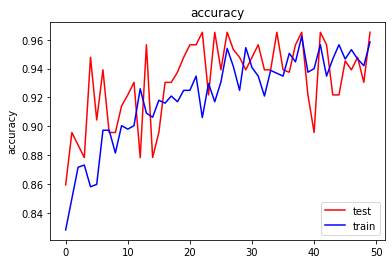

In [35]:
plt.plot(model_history.history['val_acc'], color = 'red', label = 'test')
plt.plot(model_history.history['acc'], color = 'blue', label = 'train')
plt.title('accuracy')
plt.ylabel('accuracy')
plt.legend()
plt.show()

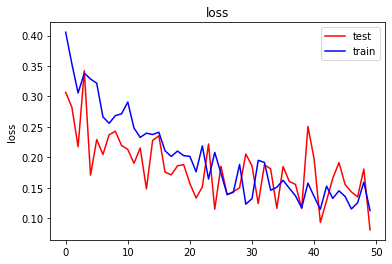

In [36]:
plt.plot(model_history.history['val_loss'], color = 'red', label = 'test')
plt.plot(model_history.history['loss'], color = 'blue', label = 'train')
plt.title('loss')
plt.ylabel('loss')
plt.legend()
plt.show()

### Save model 

In [ ]:
# # save model artchitecture 
# resnet50_model_8_up = model_history.model
# resnet50_model_8_up_json = resnet50_model_8_up.to_json()

In [ ]:
# # serialize model to JSON
# with open("../tuning_data/resnet_data/resnet50_model_8_up.json", "w") as json_file:
#     json_file.write(resnet50_model_8_up_json)

### Testing model

In [15]:
# load json and create model
def model_testing(df, model_path, weight_path, label,target_size,shuffle = False,
                 batch_size = 32, rescale=None,preprocess_func=preprocess_input,
                 class_mode ='binary', only_testing = True, old =False):
    '''
    df: the entire picture df 
    model_path: json model path
    weight_path: path for weights 
    label: eyewear, hat, or beard
    '''
    # check the whole dataframe
    sub_set = df[['pic_id',label]] 
    json_file = open(model_path, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load model weight yewear_decay_
    loaded_model.load_weights(weight_path)
    # test test data
    data_generator= create_generator(None, df,label,shuffle,batch_size,
                    rescale, preprocess_func, target_size,
                    class_mode, only_testing = only_testing)
    data_generator=data_generator[0]
    labels = df[label].map({'1':1, '0':0})
    
    loaded_model.compile(loss='binary_crossentropy',
             optimizer=optimizers.SGD(),
             metrics=['accuracy']
                        )
    y_pred = np.around(loaded_model.predict_generator(data_generator, workers=8))
    if old:
        y_pred = [1-x for x in y_pred] # for old model 
    fpr, tpr, thresholds = roc_curve(labels, y_pred)
    area = roc_auc_score(labels, y_pred)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % area)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    print(confusion_matrix(labels, y_pred))
    print(classification_report(labels, y_pred))    

### Best Resnet50 Eyewear

Found 653 validated image filenames belonging to 2 classes.


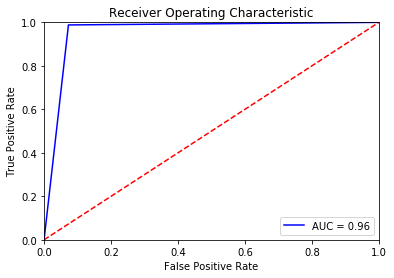

[[293  23]
 [  4 333]]
              precision    recall  f1-score   support

           0       0.99      0.93      0.96       316
           1       0.94      0.99      0.96       337

    accuracy                           0.96       653
   macro avg       0.96      0.96      0.96       653
weighted avg       0.96      0.96      0.96       653



In [67]:
model_testing(df=df,model_path='../tuning_data/resnet_data/resnet50_model_5_up.json',
             weight_path='../tuning_data/resnet_data/untracked_resnet50/best_resnet50_model_eyewear.h5',
              label='eyewear',target_size=(224,224), old = False)

### Best VGG model for eyewear

Found 653 validated image filenames belonging to 2 classes.


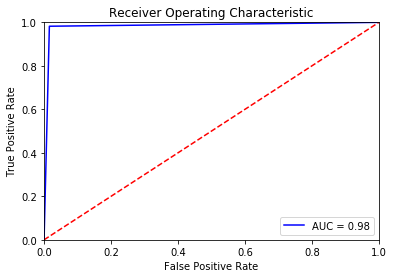

[[311   5]
 [  6 331]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       316
           1       0.99      0.98      0.98       337

    accuracy                           0.98       653
   macro avg       0.98      0.98      0.98       653
weighted avg       0.98      0.98      0.98       653



In [11]:
model_testing(df,'../tuning_data/VGG_16_tuning/vgg_model.json', 
              '../tuning_data/VGG_16_tuning/best_vgg16_model_eyewear.h5',
              'eyewear',(150,150), old = False, rescale = 1./255, preprocess_func=vgg16_preprocess.preprocess_input)

### Best resnethat

Found 653 validated image filenames belonging to 2 classes.


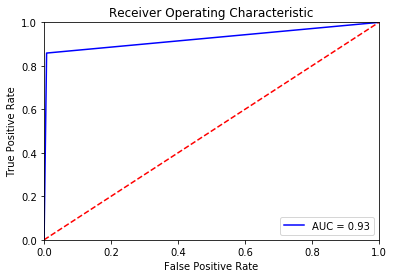

[[395   3]
 [ 36 219]]
              precision    recall  f1-score   support

           0       0.92      0.99      0.95       398
           1       0.99      0.86      0.92       255

    accuracy                           0.94       653
   macro avg       0.95      0.93      0.94       653
weighted avg       0.94      0.94      0.94       653



In [92]:
model_testing(df=df,model_path='../tuning_data/resnet_data/resnet50_model_5_up.json',
             weight_path='../tuning_data/resnet_data/untracked_resnet50/best_resnet50_model_hat.h5',
              label='hat', target_size=(224,224),old = False)

### Best VggModelforhat

Found 653 validated image filenames belonging to 2 classes.


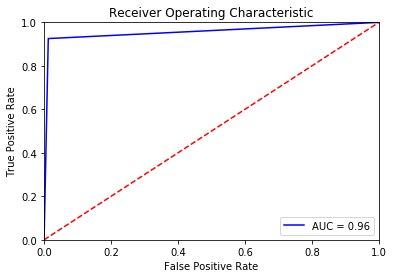

[[393   5]
 [ 19 236]]
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       398
           1       0.98      0.93      0.95       255

    accuracy                           0.96       653
   macro avg       0.97      0.96      0.96       653
weighted avg       0.96      0.96      0.96       653



In [10]:
model_testing(df,'../tuning_data/VGG_16_tuning/vgg_model.json', 
              '../tuning_data/VGG_16_tuning/best_vgg16_model_hat.h5',
              'hat',(150,150),old = False,rescale=1./255, preprocess_func=vgg16_preprocess.preprocess_input)
# chosen as best hat model for vgg16

### Best resnet50 beard model

W0905 23:06:05.504297 140427215234880 deprecation_wrapper.py:119] From /home/mindy/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:2041: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.



Found 653 validated image filenames belonging to 2 classes.


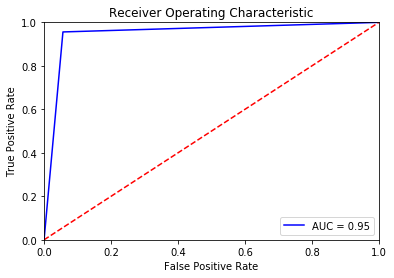

[[402  24]
 [ 10 217]]
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       426
           1       0.90      0.96      0.93       227

    accuracy                           0.95       653
   macro avg       0.94      0.95      0.94       653
weighted avg       0.95      0.95      0.95       653



In [66]:
model_testing(df=df,model_path='../tuning_data/resnet_data/resnet50_model_5_up.json',
             weight_path='../tuning_data/resnet_data/untracked_resnet50/best_resnet50_model_beard.h5',
              label='beard', target_size = (224,224), old = False)

### best VGG beard model:

Found 653 validated image filenames belonging to 2 classes.


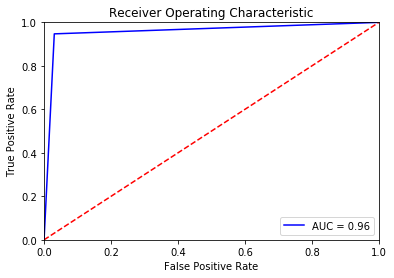

[[413  13]
 [ 12 215]]
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       426
           1       0.94      0.95      0.95       227

    accuracy                           0.96       653
   macro avg       0.96      0.96      0.96       653
weighted avg       0.96      0.96      0.96       653



In [24]:
model_testing(df,'../tuning_data/VGG_16_tuning/vgg_model.json', 
              '../tuning_data/VGG_16_tuning/best_vgg16_model_beard.h5',
              'beard',(150,150), old = False, preprocess_func=vgg16_preprocess.preprocess_input,rescale=1./255)